In [8]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from encoding_function import low_frequency_to_others

In [3]:
def add_y(df):
    df['rank'] = df['rank'].replace(0, 6)

    target_cols = [
        '단승', '복승', '삼복승'
    ]
    for i, col in enumerate(target_cols):
        condition_target = df['rank'] <= i+1
        df.loc[condition_target, col] = 1

    df[target_cols] = df[target_cols].fillna(0)
    df.drop(['rank'], axis=1, inplace=True)
    return df


ROOT_DIR = "data"
RANDOM_STATE = 999

train = pd.read_csv(os.path.join(ROOT_DIR, "train.csv"))
val = pd.read_csv(os.path.join(ROOT_DIR, "val.csv"))
test = pd.read_csv(os.path.join(ROOT_DIR, "test.csv"))


train = add_y(train)
val = add_y(val)

print(train.shape, val.shape)

(48522, 45) (8952, 45)


In [4]:
def drop_columns_from_datasets(df):
    drop_cols = [
        '연도', '회차', '일차', '경주번호',
        '금일출주경주',
        '모터번호', '전탑승선수1', '전탑승선수2',
        '보트번호', '특이사항',
        '전일성적'
    ]

    df = df.drop(drop_cols, axis=1)

    return df


train = drop_columns_from_datasets(train)
val = drop_columns_from_datasets(val)

print(train.shape, val.shape)

(48522, 34) (8952, 34)


In [5]:
def separation_course(df):
    col_list = [
        '코스_1코스', '코스_2코스', '코스_3코스', '코스_4코스', '코스_5코스', '코스_6코스'
    ]
    for col in col_list:
        df[[f'{col[3:]}_성적', f'{col[3:]}_경기수']] = df[col].fillna('').str.split('/', expand=True)

    df.drop(col_list, axis=1, inplace=True)

    return df
        


train = separation_course(train)
val = separation_course(val)

print(train.shape, val.shape)

(48522, 40) (8952, 40)


In [6]:
def apply_laplace_smoothing(df, col, global_mean, alpha):
    # 경기수 0인 값이 너무 높게 나오는 경향이 있어 분모에 상수 1 추가(없애도 됨)
    encoded_value = (df[f'{col}_성적'] * df[f'{col}_경기수'] + global_mean * alpha) / (1 + df[f'{col}_경기수'] + alpha)
    df[f'{col}_성적'] = encoded_value

    return df

def laplace_smoothing_to_course(train, val=None, alpha=1):
    col_list = [
        '1코스', '2코스', '3코스', '4코스', '5코스', '6코스'
    ]
    for col in col_list:
        train[f'{col}_성적'] = train[f'{col}_성적'].astype(float)
        train[f'{col}_경기수'] = train[f'{col}_경기수'].astype(float)
        if val is not None:
            val[f'{col}_성적'] = val[f'{col}_성적'].astype(float)
            val[f'{col}_경기수'] = val[f'{col}_경기수'].astype(float)

    # Train 데이터에서 글로벌 평균 계산
    global_means = {col: train[f'{col}_성적'].mean() for col in col_list}

    for col in col_list:
        # Train 데이터에 라플라스 스무딩 적용
        train = apply_laplace_smoothing(train, col, global_means[col], alpha)
        train.drop(f'{col}_경기수', axis=1, inplace=True)

    if val is not None:
        for col in col_list:
            # Validation 데이터에 Train에서 구한 글로벌 평균으로 라플라스 스무딩 적용
            val = apply_laplace_smoothing(val, col, global_means[col], alpha)
            val.drop(f'{col}_경기수', axis=1, inplace=True)

    if val is not None:
        return train, val
    else:
        return train


train, val = laplace_smoothing_to_course(train, val, alpha=1) # 알파가 작을수록 빈도수에 가깝세, 알파가 클수록 전체 평균에 가깝게
print(train.shape, val.shape)

(48522, 34) (8952, 34)


In [9]:
def split_last_eight_rank(df):
    for i in range(0, 4):
        df[f'최근{i+1}경기_착순'] = df['최근8경주_착순'].str[i]
    for j in range(5, 9):
        df[f'최근{j}경기_착순'] = df['최근8경주_착순'].str[j]
        
    df.drop('최근8경주_착순', axis=1, inplace=True)
        
    return df

def adjust_for_top3(df):
    col_list = [
        '최근1경기_착순', '최근2경기_착순', '최근3경기_착순', '최근4경기_착순',
        '최근5경기_착순', '최근6경기_착순', '최근7경기_착순', '최근8경기_착순'
    ]
    
    for col in col_list:
    # 순위가 1, 2, 3이 아닌 경우, 결측인 경우, 6으로 조정
    # (일반화된 성능을 위해 + 3등내에 드는게 중요)
        df[col] = df[col].apply(lambda x: x if x in ['1', '2', '3'] else '-1')

    return df


train = split_last_eight_rank(train)
train = adjust_for_top3(train)

val = split_last_eight_rank(val)
val = adjust_for_top3(val)

print(train.shape, val.shape)

(48522, 41) (8952, 41)


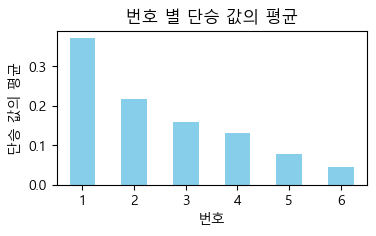

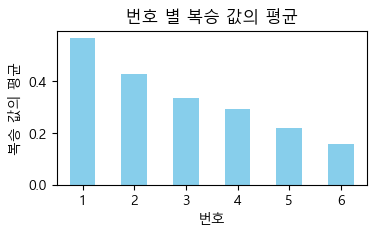

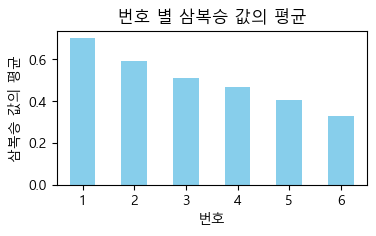

In [11]:
plt.rcParams['font.family'] = 'Malgun Gothic'

cols = [
    '단승', '복승', '삼복승'
]

for col in cols:
    mean_values = train.groupby('번호')[col].mean()
    
    plt.figure(figsize=(4, 2))
    mean_values.plot(kind='bar', color='skyblue')
    plt.title(f'번호 별 {col} 값의 평균')
    plt.xlabel('번호')
    plt.ylabel(f'{col} 값의 평균')
    plt.xticks(rotation=0)
    plt.show()

In [12]:
def shuffle_races_by_year(data, year, ratio, exclude_numbers, random_seed=None):
    if random_seed is not None:
        np.random.seed(random_seed)

    # 지정된 연도의 데이터만 필터링
    df_year = data[data['Race_ID'].str.contains(str(year))].copy()

    # 유일한 Race_ID 리스트 추출
    unique_race_ids = df_year['Race_ID'].unique()

    # 지정된 비율만큼 Race_ID를 무작위로 선택
    selected_race_ids = np.random.choice(unique_race_ids, size=int(len(unique_race_ids) * ratio), replace=False)

    # 선택된 Race_ID만 필터링
    selected_df = df_year[df_year['Race_ID'].isin(selected_race_ids)]

    # 동일한 Race_ID별로 그룹화
    grouped = selected_df.groupby('Race_ID')

    shuffled_dfs = []

    for name, group in grouped:
        # 경기 내에서 제외할 번호를 제외한 행들을 선택
        include_rows = group[~group['번호'].isin(exclude_numbers)]

        # 선택된 행들을 랜덤하게 섞음
        shuffled = include_rows.sample(frac=1.0, random_state=random_seed).reset_index(drop=True)

        # 셔플된 데이터만 리스트에 추가
        shuffled_dfs.append(shuffled)

    # 모든 셔플된 데이터를 다시 결합
    shuffled_df = pd.concat(shuffled_dfs).reset_index(drop=True)

    # 최종적으로 Race_ID 기준으로 정렬
    shuffled_df_sorted = shuffled_df.sort_values(by='Race_ID').reset_index(drop=True)

    return shuffled_df_sorted


def shuffle(df, exclude_numbers, seed=110):
    year_list = [2016, 2017, 2018, 2019, 2022]
    shuffled_df = []
    for year in year_list:
        if year <= 2018:
            ratio = 0.2
        else:
            ratio = 0.4
        shuflled_tmp = shuffle_races_by_year(df, year, ratio, exclude_numbers=[exclude_numbers], random_seed=seed)
        shuffled_df.append(shuflled_tmp)
    shuffled_df = pd.concat(shuffled_df).reset_index(drop=True)
    
    return shuffled_df


print(train.shape)
shuffle_1 = shuffle(train, 1, seed=110)
shuffle_6 = shuffle(train, 6, seed=110)
print(shuffle_1.shape, shuffle_6.shape)

train = pd.concat([train, shuffle_1, shuffle_6], axis=0).reset_index(drop=True)

print(train.shape)

(48522, 41)
(10065, 41) (10065, 41)
(68652, 41)


In [16]:
def reshape_race_data(df, players_per_race=6):
    # numpy 배열로 변환
    values = df.values

    # 데이터 형태 변환 (6개의 행을 1개의 행으로)
    reshaped_values = values.reshape(-1, players_per_race * values.shape[1])

    # 새로운 컬럼 이름 생성
    columns = [f'{col}_{i+1}번선수' for i in range(players_per_race) for col in df.columns]

    # 재구성된 DataFrame 생성
    reshaped_df = pd.DataFrame(reshaped_values, columns=columns)

    return reshaped_df

X_train = reshape_race_data(X_train, players_per_race=6)
y_train = reshape_race_data(y_train, players_per_race=6)
y_train = np.array(y_train).astype(int)

X_val = reshape_race_data(X_val, players_per_race=6)
y_val = reshape_race_data(y_val, players_per_race=6)
y_val = np.array(y_val).astype(int)

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(11442, 216) (11442, 6) (1492, 216) (1492, 6)


In [17]:
def low_to_others(train, val, threshold=5, verbose=False):
    cat_features = cal_cat_cols(train, val)

    for col in cat_features:
        unifier = low_frequency_to_others(threshold=threshold, verbose=verbose)
        train[col] = unifier.fit_transform(train[col])
        val[col] = unifier.transform(val[col])

    return train, val

X_train, X_val = low_to_others(X_train, X_val, threshold=10, verbose=True)

Columns:(최근3경기_착순_2번선수) 변환 X
Columns:(최근3경기_착순_2번선수) 변환 X
Columns:(최근6경기_착순_3번선수) 변환 X
Columns:(최근6경기_착순_3번선수) 변환 X
Columns:(성별_4번선수) 변환 X
Columns:(성별_4번선수) 변환 X
Columns:(최근5경기_착순_2번선수) 변환 X
Columns:(최근5경기_착순_2번선수) 변환 X
Columns:(성별_2번선수) 변환 X
Columns:(성별_2번선수) 변환 X
Columns:(최근4경기_착순_1번선수) 변환 X
Columns:(최근4경기_착순_1번선수) 변환 X
Columns:(최근8경기_착순_6번선수) 변환 X
Columns:(최근8경기_착순_6번선수) 변환 X
Columns:(최근8경기_착순_1번선수) 변환 X
Columns:(최근8경기_착순_1번선수) 변환 X
Columns:(최근2경기_착순_5번선수) 변환 X
Columns:(최근2경기_착순_5번선수) 변환 X
Columns:(등급_3번선수) 변환 X
Columns:(등급_3번선수) 변환 X
Columns:(FL_3번선수) 'others'로 8개 변환
Columns:(FL_3번선수) 'others'로 2개 변환
Columns:(최근4경기_착순_2번선수) 변환 X
Columns:(최근4경기_착순_2번선수) 변환 X
Columns:(최근2경기_착순_2번선수) 변환 X
Columns:(최근2경기_착순_2번선수) 변환 X
Columns:(최근5경기_착순_1번선수) 변환 X
Columns:(최근5경기_착순_1번선수) 변환 X
Columns:(선수명_1번선수) 'others'로 50개 변환
Columns:(선수명_1번선수) 변환 X
Columns:(성별_1번선수) 변환 X
Columns:(성별_1번선수) 변환 X
Columns:(성별_6번선수) 변환 X
Columns:(성별_6번선수) 변환 X
Columns:(최근7경기_착순_4번선수) 변환 X
Columns:(최근7경기_착순_4번선수) 변환 X
Colu

In [18]:
def all_precoess(train, val, target='단승', is_train=True):
    train = add_y(train)
    val = add_y(val)
    
    train = drop_columns_from_datasets(train)
    val = drop_columns_from_datasets(val)

    train = separation_course(train)
    val = separation_course(val)

    train, val = laplace_smoothing_to_course(train, val, alpha=1)

    train = split_last_eight_rank(train)
    train = adjust_for_top3(train)
    
    val = split_last_eight_rank(val)
    val = adjust_for_top3(val)

    train, val = low_to_others(train, val, threshold=10, verbose=False)

    shuffle_1 = shuffle(train, 1, seed=110)
    shuffle_6 = shuffle(train, 6, seed=110)

    train = pd.concat([train, shuffle_1, shuffle_6], axis=0)
    
    drop_cols = [
        'Race_ID', '번호', '단승', '복승', '삼복승', '선수명', '기수'
    ]
    X_train = train.drop(drop_cols, axis=1)
    y_train = train[[target]]
    X_val = val.drop(drop_cols, axis=1)
    y_val = val[[target]]

    # X_train = reshape_race_data(X_train, players_per_race=6)
    # y_train = reshape_race_data(y_train, players_per_race=6)
    y_train = np.array(y_train).astype(int)

    # X_val = reshape_race_data(X_val, players_per_race=6)
    # y_val = reshape_race_data(y_val, players_per_race=6)
    y_val = np.array(y_val).astype(int)

    X_train, X_val = low_to_others(X_train, X_val, threshold=5, verbose=False)
    
    return X_train, y_train, X_val, y_val

train = pd.read_csv(os.path.join(ROOT_DIR, "train.csv"))
val = pd.read_csv(os.path.join(ROOT_DIR, "val.csv"))

target_value='단승'
X_train, y_train, X_val, y_val = all_precoess(train, val, target=target_value, is_train=True)

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(72678, 34) (72678, 1) (8952, 34) (8952, 1)


In [19]:
X_train

,등급,성별,나이,체중,최근6회차_평균착순점,최근6회차_평균득점,최근6회차_승률,최근6회차_연대율2,최근6회차_연대율3,최근6회차_평균ST,...,5코스_성적,6코스_성적,최근1경기_착순,최근2경기_착순,최근3경기_착순,최근4경기_착순,최근5경기_착순,최근6경기_착순,최근7경기_착순,최근8경기_착순
0,A1,남,44.0,56.0,6.67,6.60,40.0,40.0,60.0,0.24,...,15.108977,30.622448,1,1,1,3,3,1,-1,-1
1,A1,남,28.0,59.0,6.17,6.03,22.2,55.6,61.1,0.19,...,15.108977,14.319642,1,1,2,-1,-1,1,-1,2
2,B2,남,32.0,59.0,3.31,2.56,12.5,12.5,25.0,0.34,...,10.335906,7.178567,-1,3,-1,-1,1,-1,-1,-1
3,A1,남,33.0,58.0,6.86,6.81,23.8,42.9,81.0,0.24,...,38.206528,23.839682,1,1,2,2,3,1,2,3
4,B1,남,35.0,61.0,4.06,3.94,5.6,16.7,33.3,0.23,...,3.445302,1.794642,-1,-1,-1,2,-1,-1,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12073,B1,남,48.0,55.0,3.56,3.33,5.6,11.1,33.3,0.27,...,2.953116,2.051019,-1,3,1,-1,-1,-1,-1,-1
12074,A1,남,43.0,55.0,6.29,6.24,35.3,41.2,64.7,0.28,...,17.238830,26.769642,2,3,-1,1,3,-1,3,1
12075,B2,남,51.0,59.0,3.44,2.75,6.3,18.8,31.3,0.25,...,24.114363,3.589284,-1,-1,3,-1,-1,-1,1,-1
12076,B1,남,43.0,60.0,6.00,5.72,16.7,38.9,61.1,0.28,...,2.953116,19.059522,3,-1,2,3,1,3,-1,-1


In [21]:
y_train = pd.Series(y_train)
df_single = pd.concat([X_train, y_train], axis=1)

ValueError: Data must be 1-dimensional, got ndarray of shape (72678, 1) instead